In [ ]:
"""
Fake News Detection System
==================================
This project implements a robust Fake News Detection system that leverages both traditional machine learning techniques and state-of-the-art deep learning models. 
It utilizes:

- Baseline Model: TF-IDF vectorization paired with Logistic Regression to establish a solid baseline for text classification.
- Advanced Model: A fine-tuned BERT-based model to capture deeper contextual nuances in the text for more accurate predictions.
The system includes data preprocessing, model training, rigorous evaluation, and real-time predictions on new articles.

Author: Joshua Dornfeldt
Date: 11/05/2024
"""

# Import necessary libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical data visualization
import tensorflow as tf  # Deep learning framework
import torch  # PyTorch framework for deep learning
import joblib  # Model persistence
import requests  # Handling HTTP requests
from sklearn.model_selection import train_test_split  # Train-test splitting
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF text vectorization
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)  # Performance evaluation metrics
from transformers import BertTokenizer, TFBertForSequenceClassification  # BERT-based NLP


c:\Users\jdorn\OneDrive\Documents\Fake_News_Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load the Dataset
def load_dataset(data_path: str) -> pd.DataFrame:
    """
    Loads the dataset from the specified CSV file path.

    Args:
        data_path (str): The absolute or relative path to the dataset CSV file.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the dataset.
    
    Raises:
        FileNotFoundError: If the specified file does not exist.
        pd.errors.EmptyDataError: If the file is empty.
    """
    print("Loading dataset...")

    try:
        df = pd.read_csv(data_path)  # Loads data into a DataFrame
        print(f"Dataset successfully loaded! Shape: {df.shape}")  # Logs the dataset size
        return df
    except FileNotFoundError:
        print(f"Error: The file at {data_path} was not found.")
        raise
    except pd.errors.EmptyDataError:
        print(f"Error: The file at {data_path} is empty.")
        raise

# Defines dataset path 
DATA_PATH = "C:/Users/jdorn/OneDrive/Documents/Fake_News_Project/archive/Testing_dataset/testingSet/processed_data.csv"

# Load the dataset
df = load_dataset(DATA_PATH)


Loading dataset...
Dataset successfully loaded! Shape: (99, 3)


In [ ]:
# Import the Necessary Library
import pandas as pd

# Loads Dataset and Analyzes Class Distribution
def load_and_analyze_dataset(file_path: str) -> pd.DataFrame:
    """
    Loads the dataset from a CSV file and displays class distribution.

    Args:
        file_path (str): Path to the dataset CSV file.

    Returns:
        pd.DataFrame: Loaded dataset as a pandas DataFrame.

    Raises:
        FileNotFoundError: If the dataset file is not found.
        pd.errors.EmptyDataError: If the dataset file is empty.
        pd.errors.ParserError: If the CSV file cannot be parsed correctly.
    """
    print("Loading dataset...")

    try:
        # Loads the dataset into a DataFrame
        df = pd.read_csv(file_path)

        # Displays dataset statistics
        print(f"Dataset successfully loaded! Shape: {df.shape}")  
        print("\nClass Distribution (Real News vs Fake News):")
        print(df['Label'].value_counts())  # Counts the occurrences of each label

        return df

    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
        raise
    except pd.errors.EmptyDataError:
        print(f"Error: The file at {file_path} is empty.")
        raise
    except pd.errors.ParserError:
        print(f"Error: The file at {file_path} could not be parsed.")
        raise

# Defines the file path of the dataset 
DATA_FILE_PATH = "C:/Users/jdorn/OneDrive/Documents/Fake_News_Project/archive/Testing_dataset/testingSet/processed_data.csv"

# Loads dataset and displays the label distribution
df = load_and_analyze_dataset(DATA_FILE_PATH)


Loading dataset...
Dataset successfully loaded! Shape: (99, 3)

Class Distribution (Real News vs Fake News):
Label
1    50
0    49
Name: count, dtype: int64


In [ ]:
# Displays the Dataset Summary and First Few Rows of the Dataset
def summarize_dataset(df: pd.DataFrame):
    """
    Displays basic information and the first few rows of the dataset.

    Args:
        df (pd.DataFrame): The dataset to be summarized.

    Returns:
        tuple: (DataFrame head, None)
    """
    print("\n--- Dataset Overview ---")
    
    # Displays basic dataset information
    print("\nDataset Info:")
    df.info()

    # Displays the first few rows of the dataset
    print("\nFirst Few Records:")
    return df.head(), None  # Returning None explicitly for df.info(), as it prints the output but does not return a value

# Summarizes the dataset
summarize_dataset(df)



--- Dataset Overview ---

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    99 non-null     object
 1   Article  99 non-null     object
 2   Label    99 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ KB

First Few Records:


(                                               Title  \
 0  Germany and France signal willingness to delay...   
 1  Ramnit Computer Worm Compromises 45K Facebook ...   
 2  5.5 Hours, No CCTVs, No Showering of Cash: SC ...   
 3  Is Aspartame Responsible for ‘An Epidemic of M...   
 4  ‘Breaking Bad’ Star Bryan Cranston Diagnosed W...   
 
                                              Article  Label  
 0  Germany and France have signalled their willin...      0  
 1  A computer worm that has traditionally targete...      0  
 2  \nNEW DELHI — The Supreme Court on Thursday se...      0  
 3  I have spent several days lecturing at the WOR...      1  
 4  HOLLYWOOD, California – \r\n\r\nIn a tragic tw...      1  ,
 None)

In [ ]:
# =============================
# Data Preprocessing - Splitting the Data
# =============================

def split_data(df: pd.DataFrame, test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets.

    Args:
        df (pd.DataFrame): The dataset containing the articles and labels.
        test_size (float): Proportion of the dataset to include in the test split. Default is 0.2 (20%).
        random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
        tuple: X_train, X_test, y_train, y_test (split training and test data)
    """
    print("\nSplitting the dataset into training and testing sets...")

    # Extract features (news articles) and labels (real/fake classification)
    X = df['Article']  # Feature: News text
    y = df['Label']    # Target: Classification label (Real = 0, Fake = 1)

    # Performs the train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Training Set Size: {X_train.shape[0]} samples")
    print(f"Testing Set Size: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test

# Executes the function to split the data
X_train, X_test, y_train, y_test = split_data(df)



Splitting the dataset into training and testing sets...
Training Set Size: 79 samples
Testing Set Size: 20 samples


In [ ]:
# ============================================
# TF-IDF Vectorization & Logistic Regression Model 
# ============================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(X_train, X_test, y_train):
    """
    Applies TF-IDF vectorization and trains a Logistic Regression model 
    to classify fake vs. real news articles.

    Args:
        X_train (pd.Series): Training set of news articles.
        X_test (pd.Series): Testing set of news articles.
        y_train (pd.Series): Training set labels (0 = Real News, 1 = Fake News).

    Returns:
        tuple: 
            logistic_model (LogisticRegression) - Trained logistic regression model.
            X_train_tfidf (sparse matrix) - Transformed TF-IDF feature set for training.
            X_test_tfidf (sparse matrix) - Transformed TF-IDF feature set for testing.
            y_pred_baseline (np.array) - Predicted labels for the test set.
            y_prob_baseline (np.array) - Predicted probabilities for the test set.
    """
    print("\nApplying TF-IDF vectorization and training Logistic Regression...")

    # TF-IDF Vectorization (Includes unigrams, bigrams, and trigrams for better context)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words="english", max_features=5000)
    
    # Transforms the text data into TF-IDF features
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Trains the Logistic Regression model
    logistic_model = LogisticRegression(max_iter=1000, random_state=42)
    logistic_model.fit(X_train_tfidf, y_train)

    # Predict labels and probabilities on the test set
    y_pred_baseline = logistic_model.predict(X_test_tfidf)
    y_prob_baseline = logistic_model.predict_proba(X_test_tfidf)[:, 1]

    print("Logistic Regression model training complete.")
    
    return logistic_model, X_train_tfidf, X_test_tfidf, y_pred_baseline, y_prob_baseline

# Executes the function to train the model
logistic_model, X_train_tfidf, X_test_tfidf, y_pred_baseline, y_prob_baseline = train_logistic_regression(X_train, X_test, y_train)



Applying TF-IDF vectorization and training Logistic Regression...
Logistic Regression model training complete.


In [ ]:
# ============================================
# Evaluate Logistic Regression Model Performance
# ============================================

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

def evaluate_logistic_model(y_test, y_pred, y_prob):
    """
    Evaluates the performance of the Logistic Regression model using accuracy, ROC-AUC score,
    and a detailed classification report.

    Args:
        y_test (np.array or pd.Series): True labels for the test set.
        y_pred (np.array): Predicted labels from the logistic model.
        y_prob (np.array): Predicted probabilities for the positive class (fake news).

    Returns:
        dict: Contains accuracy and ROC-AUC scores for logging purposes.
    """
    print("\nEvaluating Logistic Regression Model Performance...")
    
    # Computes the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Prints the evaluation results
    print("\nBaseline Model - Logistic Regression")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Returns the results as a dictionary
    return {"accuracy": accuracy, "roc_auc": roc_auc}

# Executes the evaluation
logistic_metrics = evaluate_logistic_model(y_test, y_pred_baseline, y_prob_baseline)



Evaluating Logistic Regression Model Performance...

Baseline Model - Logistic Regression
Accuracy: 0.85
ROC-AUC: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



In [ ]:
## ============================================
# Load BERT Tokenizer & Encode Test Data
# ============================================

from transformers import BertTokenizer
import torch

# Loads a pre-trained BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_texts(texts, tokenizer, max_len=256):
    """
    Encodes a list of text samples into tokenized BERT inputs with padding and truncation.

    Args:
        texts (list or pd.Series): List of text samples to encode.
        tokenizer (BertTokenizer): Preloaded BERT tokenizer for processing text.
        max_len (int): Maximum sequence length for padding/truncation.

    Returns:
        dict: Tokenized inputs containing input_ids and attention_mask as PyTorch tensors.
    """
    return tokenizer(
        list(texts),
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="pt" 
    )

# Encodes the test dataset
print("Encoding test dataset for BERT model...")
X_test_encoded = encode_texts(X_test, bert_tokenizer)

# Ensure computations are performed on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Moves the encoded input tensors to the selected device
input_ids = X_test_encoded["input_ids"].to(device)
attention_mask = X_test_encoded["attention_mask"].to(device)

print(f"Test data encoded and moved to {device}")



Encoding test dataset for BERT model...
Test data encoded and moved to cpu


In [ ]:
# ============================================
# Load & Fine-Tune BERT Model for Fake News Detection
# ============================================

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F

# --------------------------------------------
# Step 1: Loads the Pretrained BERT Model & Tokenizer
# --------------------------------------------
print("Loading BERT tokenizer and model...")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# --------------------------------------------
# Step 2: Encodes the Text Data for Training
# --------------------------------------------
def encode_texts(texts, tokenizer, max_len=256):
    """
    Tokenizes and encodes input text into tensors suitable for BERT.
    """
    return tokenizer(
        list(texts),
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="pt"  
    )

# Ensures that X_train, X_test, y_train, and y_test are defined from the dataset.
print("Encoding training and test data...")
train_encodings = encode_texts(X_train, bert_tokenizer)
test_encodings = encode_texts(X_test, bert_tokenizer)

# --------------------------------------------
# Step 3: Converts the Encoded Data to PyTorch Dataset
# --------------------------------------------
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

print("Creating PyTorch datasets...")
train_data = FakeNewsDataset(train_encodings, y_train.tolist())
test_data = FakeNewsDataset(test_encodings, y_test.tolist())

# --------------------------------------------
# Step 4: Fine-Tune BERT Model with Improved Hyperparameters and Evaluation Metrics
# --------------------------------------------

# Defines a compute_metrics function to evaluate accuracy and ROC-AUC during training
def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions
    preds = np.argmax(logits, axis=1)
    
    # Computes the probabilities for the positive class using softmax
    probs = F.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    accuracy = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs)
    return {"accuracy": accuracy, "roc_auc": roc_auc}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,            
    per_device_train_batch_size=8, 
    evaluation_strategy="epoch",   
    learning_rate=2e-5,            
    warmup_steps=500,              
    weight_decay=0.01,             # Uses penalties on large weights to help prevent the model from overfitting
    logging_dir='./logs',
)

trainer = Trainer(
    model=bert_model, 
    args=training_args, 
    train_dataset=train_data, 
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

print("Starting BERT fine-tuning...")
trainer.train()

# --------------------------------------------
# Step 5: Save Fine-Tuned Model
# --------------------------------------------
print("Saving fine-tuned BERT model...")
# Disables safe serialization to avoid file access issues
bert_model.save_pretrained("./bert_finetuned", safe_serialization=False)
bert_tokenizer.save_pretrained("./bert_finetuned")

# --------------------------------------------
# Step 6: Reload the Fine-Tuned Model for Predictions
# --------------------------------------------
print("Reloading fine-tuned BERT model for inference...")
bert_model = BertForSequenceClassification.from_pretrained("./bert_finetuned")

# --------------------------------------------
# Step 7: Make Predictions with Fine-Tuned BERT
# --------------------------------------------
def predict_bert(text):
    """
    Predicts whether a given article is real or fake news using fine-tuned BERT.
    """
    encoded_input = encode_texts([text], bert_tokenizer)
    with torch.no_grad():  
        logits = bert_model(**encoded_input).logits
    pred = torch.argmax(logits, dim=1).item()
    return "Fake News" if pred == 1 else "Real News"

print("BERT model is ready for predictions!")


Loading BERT tokenizer and model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding training and test data...
Creating PyTorch datasets...


c:\Users\jdorn\OneDrive\Documents\Fake_News_Project\venv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting BERT fine-tuning...


C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,No log,0.698388,0.450000,0.600000
2,No log,0.696749,0.500000,0.610000
3,No log,0.694642,0.550000,0.600000
4,No log,0.693316,0.600000,0.600000
5,No log,0.691647,0.600000,0.590000
6,No log,0.689526,0.600000,0.600000


C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val i

Saving fine-tuned BERT model...
Reloading fine-tuned BERT model for inference...
BERT model is ready for predictions!


In [ ]:
# ============================================================
# Fine-Tuning BERT for Fake News Detection
# ============================================================

import torch
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments

# ------------------------------------------------------------
# Step 1: Moves Model to GPU 
# ------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure the model is on the correct device
bert_model.to(device)

# ------------------------------------------------------------
# Step 2: Defines Training Arguments for BERT Fine-Tuning
# ------------------------------------------------------------

training_args = TrainingArguments(
    output_dir="./results",             # Directory to save model checkpoints
    num_train_epochs=6,                 # Increased epochs for improved learning
    per_device_train_batch_size=8,      
    per_device_eval_batch_size=8,       
    warmup_steps=500,                   
    weight_decay=0.01,                   # Uses penalties on large weights to help prevent the model from overfitting
    logging_dir="./logs",                
    logging_steps=10,                   
    evaluation_strategy="epoch",         # Evaluate the model after each epoch
    save_strategy="epoch",               # Save checkpoints after every epoch
    load_best_model_at_end=True          
)

# ------------------------------------------------------------
# Step 3: Create Trainer Instance
# ------------------------------------------------------------

trainer = Trainer(
    model=bert_model,       # Fine-tuned BERT model
    args=training_args,     # Training configurations
    train_dataset=train_data,  # Training dataset
    eval_dataset=test_data     # Evaluation dataset
)

# ------------------------------------------------------------
# Step 4: Train the Model
# ------------------------------------------------------------

print("Starting BERT fine-tuning...")

trainer.train()

print("Training complete. Model is fine-tuned and ready for evaluation.")


Using device: cpu
Starting BERT fine-tuning...


c:\Users\jdorn\OneDrive\Documents\Fake_News_Project\venv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.091600,0.634249
2,0.085600,0.654184
3,0.081400,0.671641
4,0.068000,0.691827
5,0.063000,0.720491
6,0.047700,0.758093


C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3378742198.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val i

Training complete. Model is fine-tuned and ready for evaluation.


In [ ]:
# ============================================================
# BERT Model Inference - Fake News Detection
# ============================================================

import torch

# ------------------------------------------------------------
# Step 1: Move Model and Test Data to GPU
# ------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Converts the test inputs to PyTorch tensors and move them to the correct device
input_ids = torch.tensor(X_test_encoded["input_ids"]).to(device)
attention_mask = torch.tensor(X_test_encoded["attention_mask"]).to(device)

# Ensures that the model is on the correct device and set to evaluation mode
bert_model.to(device)
bert_model.eval()  # Disables dropout layers and improves inference reliability

# ------------------------------------------------------------
# Step 2: Perform Inference Using Fine-Tuned BERT
# ------------------------------------------------------------

print("Running inference on test data...")

with torch.no_grad():  
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits  # Extracts raw model predictions

# ------------------------------------------------------------
# Step 3: Convert Model Outputs to Class Labels
# ------------------------------------------------------------

# Convert logits (raw scores) into class labels (0 = Real News, 1 = Fake News)
y_pred_oracle_labels = torch.argmax(logits, axis=1).cpu().numpy()  # Moves data to CPU for processing

print("Inference complete. Predictions ready for evaluation.")


Using device: cpu
Running inference on test data...


C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3154277584.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(X_test_encoded["input_ids"]).to(device)
C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3154277584.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(X_test_encoded["attention_mask"]).to(device)


Inference complete. Predictions ready for evaluation.


In [ ]:
# ============================================================
# BERT Model Evaluation - Fake News Detection
# ============================================================

import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ------------------------------------------------------------
# Step 1: Convert Model Outputs to Probabilities
# ------------------------------------------------------------

print("Converting logits to probabilities...")

# Applies softmax to logits to obtain class probabilities
y_pred_oracle_probs = F.softmax(torch.tensor(logits), dim=1).cpu().numpy()

print("Conversion complete. Proceeding with evaluation metrics.")

# ------------------------------------------------------------
# Step 2: Evaluate BERT Model Performance
# ------------------------------------------------------------

print("\n Oracle Model - Fine-Tuned BERT Performance")

# Computes the accuracy
accuracy = accuracy_score(y_test, y_pred_oracle_labels)
print(f"Accuracy: {accuracy:.2f}")

# Computes the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_oracle_probs[:, 1])
print(f"ROC-AUC: {roc_auc:.2f}")

# Displays the detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_oracle_labels))

print("Evaluation complete.")


Converting logits to probabilities...
Conversion complete. Proceeding with evaluation metrics.

 Oracle Model - Fine-Tuned BERT Performance
Accuracy: 0.65
ROC-AUC: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.70      0.67        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20

Evaluation complete.


C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\2346250104.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_oracle_probs = F.softmax(torch.tensor(logits), dim=1).cpu().numpy()


In [ ]:
# ============================================================
# Model Performance Comparison - Logistic Regression vs BERT
# ============================================================

import torch.nn.functional as F  # Import softmax for probability conversion
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import IPython.display as display

# ------------------------------------------------------------
# Step 1: Compute Model Evaluation Metrics
# ------------------------------------------------------------

print("Calculating model accuracy and ROC-AUC scores...")

# Create a DataFrame to store results for both models
model_results = pd.DataFrame({
    "Model": ["Logistic Regression", "BERT"],
    
    # Computes accuracy for both models
    "Accuracy": [
        accuracy_score(y_test, y_pred_baseline) * 100,  # Logistic Regression
        accuracy_score(y_test, y_pred_oracle_labels) * 100  # BERT
    ],
    
    # Computes ROC-AUC score for both models
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_baseline) * 100,  # Logistic Regression
        roc_auc_score(y_test, F.softmax(logits, dim=1)[:, 1].cpu().numpy()) * 100  # BERT model with Softmax applied
    ]
})

print("Model evaluation complete. Results stored in 'model_results'.")

# ------------------------------------------------------------
# Step 2: Display Results in Jupyter Notebook
# ------------------------------------------------------------

print("Displaying model comparison results...")

# Use IPython display to render the DataFrame nicely in Jupyter Notebook
display.display(model_results)

print("Model comparison table displayed successfully.")


Calculating model accuracy and ROC-AUC scores...
Model evaluation complete. Results stored in 'model_results'.
Displaying model comparison results...


,Model,Accuracy,ROC-AUC
0,Logistic Regression,85.0,88.0
1,BERT,65.0,84.0


Model comparison table displayed successfully.


Generating model performance comparison plots...


C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3425166068.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=model_results, palette="viridis")
C:\Users\jdorn\AppData\Local\Temp\ipykernel_18912\3425166068.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="ROC-AUC", data=model_results, palette="coolwarm")


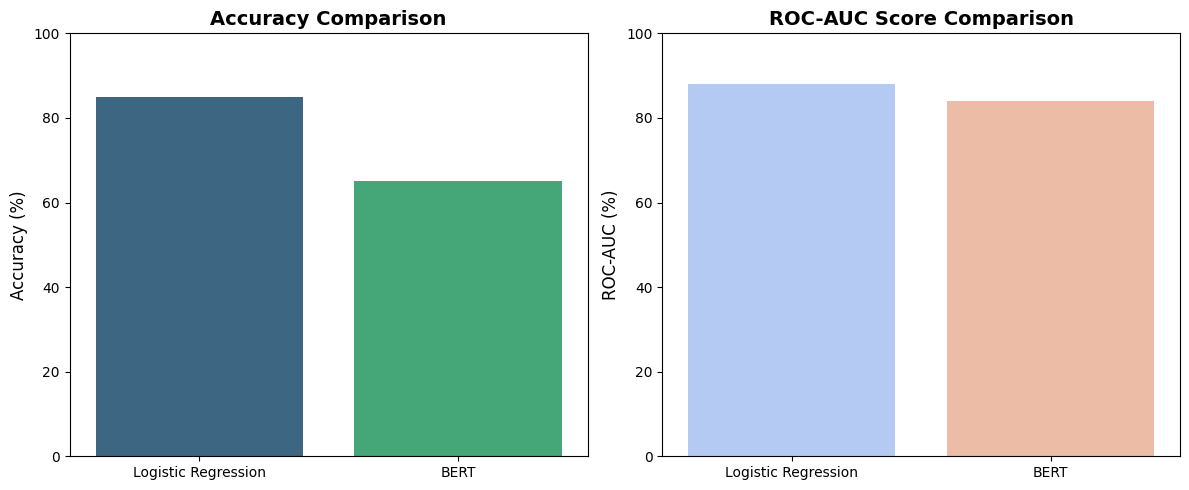

Visualization complete: Accuracy and ROC-AUC comparison displayed.


In [ ]:
# ====================================================================
# Model Performance Visualization - Accuracy & ROC-AUC Comparison
# ====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# Step 1: Set Up the Plot
# ------------------------------------------------------------

print("Generating model performance comparison plots...")

# Define a figure size for readability
plt.figure(figsize=(12, 5))

# ------------------------------------------------------------
# Step 2: Accuracy Comparison Bar Chart
# ------------------------------------------------------------

plt.subplot(1, 2, 1)  # Defines a first subplot (1 row, 2 columns, first plot)
sns.barplot(x="Model", y="Accuracy", data=model_results, palette="viridis")

# Customizes a plot appearance
plt.title("Accuracy Comparison", fontsize=14, fontweight="bold")
plt.ylim(0, 100)  # Sets a consistent scale
plt.xlabel("")  # Remove the x-axis label for cleaner visualization
plt.ylabel("Accuracy (%)", fontsize=12)

# ------------------------------------------------------------
# Step 3: ROC-AUC Comparison Bar Chart
# ------------------------------------------------------------

plt.subplot(1, 2, 2)  # Defines a second subplot (1 row, 2 columns, second plot)
sns.barplot(x="Model", y="ROC-AUC", data=model_results, palette="coolwarm")

# Customizes plot appearance
plt.title("ROC-AUC Score Comparison", fontsize=14, fontweight="bold")
plt.ylim(0, 100)  # Keeps the scale consistent
plt.xlabel("")  # Removes the x-axis label
plt.ylabel("ROC-AUC (%)", fontsize=12)

# ------------------------------------------------------------
# Step 4: Final Adjustments and Display
# ------------------------------------------------------------

plt.tight_layout()  # Optimizes spacing
plt.show()  # Displays the plots

print("Visualization complete: Accuracy and ROC-AUC comparison displayed.")


In [ ]:
# =============================================================
# Fake News Detection - Model Evaluation on Real Articles
# =============================================================

import pandas as pd
import joblib
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# ------------------------------------------------------------
# Step 1: Load Pre-Trained Models & Vectorizer
# ------------------------------------------------------------

print("Loading pre-trained models and vectorizer...")

# Loads the TF-IDF vectorizer and also trained Logistic Regression model
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
logistic_model = joblib.load("logistic_regression.pkl")

# Loads the BERT model and tokenizer for classification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

print("Models successfully loaded.")

# ------------------------------------------------------------
# Step 2: Define Real & Fake News Test Samples
# ------------------------------------------------------------

print("Preparing test articles for evaluation...")

# Sample test cases with actual labels (0 = Real, 1 = Fake) to test if the program is working
test_articles = [
    {"text": "NASA announces new mission to Mars set for 2030, focusing on human exploration.", "label": 0},  # Real 
    {"text": "Breaking: Scientists confirm the Earth is flat, sparking worldwide debate.", "label": 1},  # Fake
]

print(f" {len(test_articles)} test articles prepared.")

# ------------------------------------------------------------
# Step 3: Define Prediction Functions for Both Models
# ------------------------------------------------------------

def predict_logistic(text):
    """
    Predicts whether a given article is real or fake using the Logistic Regression model.

    Args:
        text (str): The news article content.

    Returns:
        str: "Fake News" if classified as fake, else "Real News".
    """
    text_tfidf = tfidf_vectorizer.transform([text])  # Converts the text to TF-IDF features
    pred = logistic_model.predict(text_tfidf)[0]  # Predicts a label (0 = Real, 1 = Fake)
    return "Fake News" if pred == 1 else "Real News"

def predict_bert(text):
    """
    Predicts whether a given article is real or fake using the fine-tuned BERT model.

    Args:
        text (str): The news article content.

    Returns:
        str: "Fake News" if classified as fake, else "Real News".
    """
    # Tokenizes the input text for BERT
    inputs = bert_tokenizer(
        text, return_tensors="tf", max_length=512, truncation=True, padding="max_length"
    )

    # Gets the model predictions 
    logits = bert_model(inputs["input_ids"], inputs["attention_mask"]).logits
    pred = tf.argmax(logits, axis=1).numpy()[0]  # Convert logits to a predicted label (0 or 1)
    return "Fake News" if pred == 1 else "Real News"

print("Prediction functions are ready.")

# ------------------------------------------------------------
# Step 4: Run Predictions & Compare Results
# ------------------------------------------------------------

print("\nEvaluating model predictions...\n")

for article in test_articles:
    # Get an actual label as human-readable text
    true_label = "Fake News" if article["label"] == 1 else "Real News"

    # Predict using both models
    logistic_pred = predict_logistic(article["text"])
    bert_pred = predict_bert(article["text"])

    # Displays the results
    print("-------------------------------------------------")
    print(f" **Article:** {article['text']}")
    print(f" **Actual Label:** {true_label}")
    print(f" Logistic Regression Prediction: {logistic_pred}")
    print(f" BERT Prediction: {bert_pred}")

print("\n Model evaluation complete.")
 

Loading pre-trained models and vectorizer...



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models successfully loaded.
Preparing test articles for evaluation...
 2 test articles prepared.
Prediction functions are ready.

Evaluating model predictions...

-------------------------------------------------
 **Article:** NASA announces new mission to Mars set for 2030, focusing on human exploration.
 **Actual Label:** Real News
 Logistic Regression Prediction: Fake News
 BERT Prediction: Real News
-------------------------------------------------
 **Article:** Breaking: Scientists confirm the Earth is flat, sparking worldwide debate.
 **Actual Label:** Fake News
 Logistic Regression Prediction: Fake News
 BERT Prediction: Real News

 Model evaluation complete.
